# COMBLE-MIP Tutorial

* Please direct any questions to Tim Juliano (NSF NCAR, tjuliano@ucar.edu)

* The below notebook focuses on the DOE-funded Cold-Air Outbreaks in the Marine Boundary Layer Experiment (COMBLE) that took place from 2019-2020. More information about COMBLE can be found in Geerts et al. (2022). <br /><ins>Reference</ins><br />Geerts, B., et al., 2022: The COMBLE campaign: A study of marine boundary layer clouds in Arctic cold-air outbreaks, Bull. Amer. Meteor. Soc, 103, E1371–E1389. https://doi.org/10.1175/BAMS-D-21-0044.1

* To better understand the fundamental mixed-phase clouds that accompany cold-air outbreaks (CAOs), we initiated the COMBLE Model-Observation Intercomparison Project (MIP) for large-eddy simulation (LES) and single-column models (SCMs) in late 2021. The MIP examines a CAO event on 13 March 2020 that was observed during COMBLE. More details about COMBLE MIP may be found [here](https://arm-development.github.io/comble-mip/).

* The main goal of this notebook is to become more familiar with working with LES and SCM model outputs and comparing them to observations. We will cover the following topics in this notebook:
    1. Reading MIP model outputs
    2. Plotting MIP model outputs
    3. Plotting ground-based ARM observations, satellite retrievals, and misc data sets

## Imports and path settings

Let’s get started with some data! But first, we need to import some libraries and define some functions. We'll do this through a Python script called 'functions_plotting_tutorial.py'

In [44]:
%run functions_plotting_tutorial.py

Point to the directory of the LES outputs

In [45]:
les_output_dir = './output_les/'

## Read in observational data

Here, we consider DOE ARM data streams, several satellite data sources, as well two reanalyses products. Each of these data streams is read in using a unique function that is defined in 'functions_plotting_tutorial.py'. These data sets are important for us to evaluate our models.

**<ins>NOTE</ins>: We have already post-processed each of the below observational data sets. We expect that you will use the post-processed satellite and reanalyses data sets. However, since one of the foci of the Summer School is becoming more comfortable working with ARM data, you <ins>must</ins> work with the raw ARM data sets from the Data Discovery and post-process the data yourself!**

In [46]:
# Load DOE ARM data streams first
## radiosondes
rs_dat = load_rs(t_filter = 7.)
# KAZR
kazrkollias_dat = load_kazrkollias(t_filter = 6.,aux_dat=rs_dat) ## here using radiosonde profiles to estimate CTT
kazrclough_dat = load_kazrclough(t_filter = 6.)
# AERI
aeri_dat = load_aeri(t_filter = 0.5)
# radiative fluxes
radflux_dat = load_radflux(t_filter = 6.)
# surface fluxes
srfflux_dat = load_flux(t_filter = 6.)


## Load satellite data streams next
# multisensor advanced climatology of liquid water path (MAC-LWP)
# Elsaesser, G. S., O’Dell, C. W., Lebsock, M. D., Bennartz, R., Greenwald, T. J., & Wentz, F. J. (2017).
# The multisensor advanced climatology of liquid water path (MAC-LWP). Journal of Climate, 30(24), 10193-10210.
maclwp_dat = load_maclwp(t_filter = 0.)
# MODIS
modis_dat = load_modis(t_filter = 0.,sza_filter = 65.)
# VIIRS
viirs_dat = load_viirs(t_filter = 0.,sza_filter = 65.)
# Sentinel
sentinel_dat = load_sentinel(t_filter = 0.,sza_filter = 65.)
# CALIPSO (note the increased time window)
calipso_dat = load_calipso(t_filter = 3.)


## Load reanlyses data streams last
# ERA5
era5_1d, era5_2d = load_era5()
# CARRA
carra_dat = load_carraflux()

data_files/anxsondewnpnM1.b1.20200313.052700.cdf
data_files/anxsondewnpnM1.b1.20200313.172600.cdf
data_files/anxsondewnpnM1.b1.20200313.232200.cdf
data_files/anxsondewnpnM1.b1.20200313.112600.cdf
KAZR (Kollias): here using auxiliary field to estimate cloud-top temperature


/glade/derecho/scratch/tjuliano/doe_comble/doe_arm_summer_school/arm-summer-school-2024/tutorials/comble/functions_plotting_tutorial.py:240: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux_dat['zdiff'] = np.abs(aux_dat['zf'] - np.float(p_df['zi']))
/glade/derecho/scratch/tjuliano/doe_comble/doe_arm_summer_school/arm-summer-school-2024/tutorials/comble/functions_plotting_tutorial.py:241: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux_dat['zdiff.25'] = np.abs(aux_dat['zf'] - np.float(p_df['zi.25']))
/glade/derecho/scratch/tjuliano/doe_comble/doe_arm_summer_school/arm-summer-school-2024/tutorials/comble/functions_plotting_tutorial.py:242: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  aux_dat[

./data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc


## Read in MIP model outputs

Let's compare two participating LES models: the Weather Research and Forecasting (WRF) model and the Distributed Hydrodynamic-Aerosol-Radiation-Microphysics Application (DHARMA).

In [47]:
# we will use the 'FixN' model configuration (this is the baseline setup for the MIP)
# more details about the MIP model configuration:
# https://arm-development.github.io/comble-mip/main_configuration.html
sim_keyword_wrf = 'wrf/WRF_Lx25_dx100_FixN.'
sim_keyword_dharma = 'dharma/DHARMA_Lx25_dx200_FixN.'

First, we will load in specified 1D variables (time dimension only) from the simulation outputs of these two models to compare with some of the observational products. It is important to understand how close our simulations are to the reanalyses and observations with respect to surface-related variables because CAOs are very strongly surface forced. Turbulent exchanges between the ocean and atmosphere largely dictate how the cloud system evolves.

In [48]:
# define variables
var_vec_1d = ['hfss','hfls','ts'] # surface sensible and latent heat flux, as well as skin temperature
var_vec_2d = []
# wrf
df_col_wrf_1d,df_col_wrf_2d = load_sims(les_output_dir,var_vec_1d,var_vec_2d,t_shift=-2,
                                        keyword=sim_keyword_wrf)
# dharma
df_col_dharma_1d,df_col_dharma_2d = load_sims(les_output_dir,var_vec_1d,var_vec_2d,t_shift=-2,
                                              keyword=sim_keyword_dharma)

Loading variables: f(time)
output_les/wrf/WRF_Lx25_dx100_FixN.nc
Loading variables: f(time,height)
output_les/wrf/WRF_Lx25_dx100_FixN.nc
Loading variables: f(time)
output_les/dharma/DHARMA_Lx25_dx200_FixN.nc
Loading variables: f(time,height)
output_les/dharma/DHARMA_Lx25_dx200_FixN.nc


## Plotting observations and MIP outputs

#### Let's now read in and plot some surface variables
hfss --> surface sensible heat flux (W/m2)\
hfls --> surface latent heat flux (W/m2)\
ts --> skin temperature (K)\
Note that t=0h corresponds to the ice edge

/glade/work/tjuliano/conda-envs/myclone/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/glade/work/tjuliano/conda-envs/myclone/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


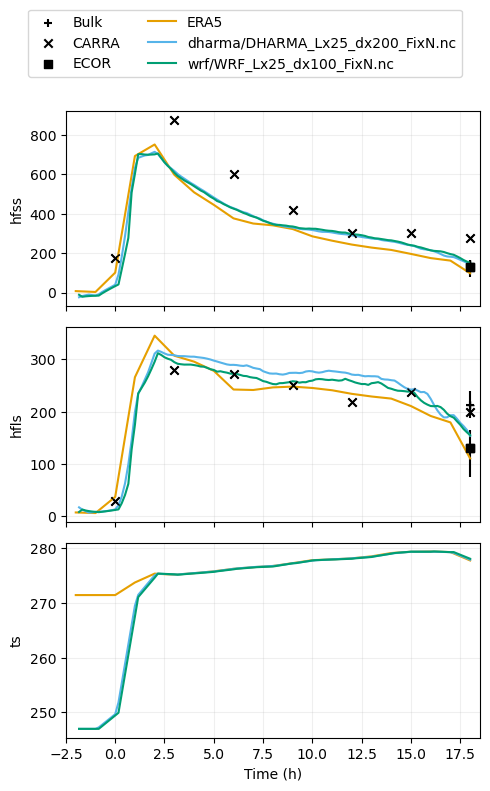

In [49]:
## plot variables that have only time dependence
plot_1d(pd.concat([df_col_wrf_1d,df_col_dharma_1d,era5_1d,carra_dat,srfflux_dat]),var_vec_1d)

#### Let's now read in and plot some cloud-centric variables
cth --> cloud top height (m)\
od --> optical depth (-)\
lwp --> liquid water path (g/m2)\
iwp --> ice water path (g/m2)\
ctt --> cloud top temperature (K)

In [50]:
# define variables
var_vec_1d = ['lwpr','lwpc','iwp','od'] # variables without ERA5 (shorter time axis)
var_vec_2d = ['theta','qv','qlc','qlr','qic','qis','qig','ua','va','ta']
# wrf
df_col_wrf_1d,df_col_wrf_2d = load_sims(les_output_dir,var_vec_1d,var_vec_2d,t_shift=-2,
                                        keyword=sim_keyword_wrf,diag_zi_ctt=True)
# dharma
df_col_dharma_1d,df_col_dharma_2d = load_sims(les_output_dir,var_vec_1d,var_vec_2d,t_shift=-2,
                                              keyword=sim_keyword_dharma,diag_zi_ctt=True)

Loading variables: f(time)
output_les/wrf/WRF_Lx25_dx100_FixN.nc
Loading variables: f(time,height)
output_les/wrf/WRF_Lx25_dx100_FixN.nc
computing inversion height, cloud-top height, and cloud-top temperature
using liquid(-ice) potential temperature
Loading variables: f(time)
output_les/dharma/DHARMA_Lx25_dx200_FixN.nc
Loading variables: f(time,height)
output_les/dharma/DHARMA_Lx25_dx200_FixN.nc
computing inversion height, cloud-top height, and cloud-top temperature
using liquid(-ice) potential temperature


/glade/work/tjuliano/conda-envs/myclone/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/glade/work/tjuliano/conda-envs/myclone/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


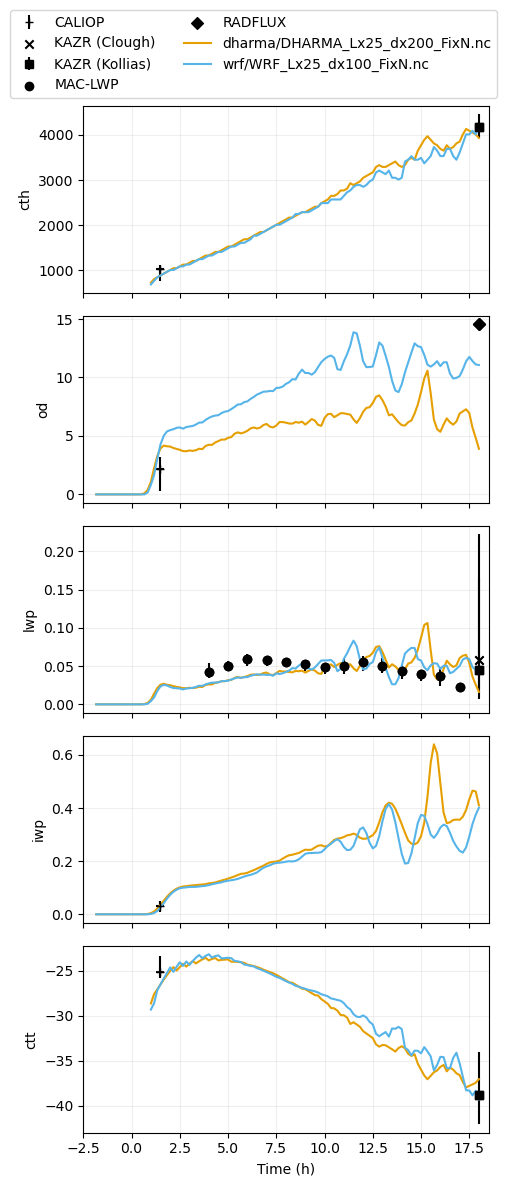

In [51]:
plot_1d(pd.concat([df_col_wrf_1d,df_col_dharma_1d,maclwp_dat,kazrkollias_dat,kazrclough_dat,calipso_dat,radflux_dat]),['cth','od','lwp','iwp','ctt'])

#### And lastly, some vertical profiles. Note that we have ERA5 during the entire particle trajectory and COMBLE measurements only at the last time (t=18h)
ta --> air temperature (K)\
theta --> air potential temperature (K)\
qv --> water vapor mixing ratio (kg/kg)\
ws --> wind speed (m/s)\
wd --> wind direction (deg)

Computing wind speed
Computing wind direction


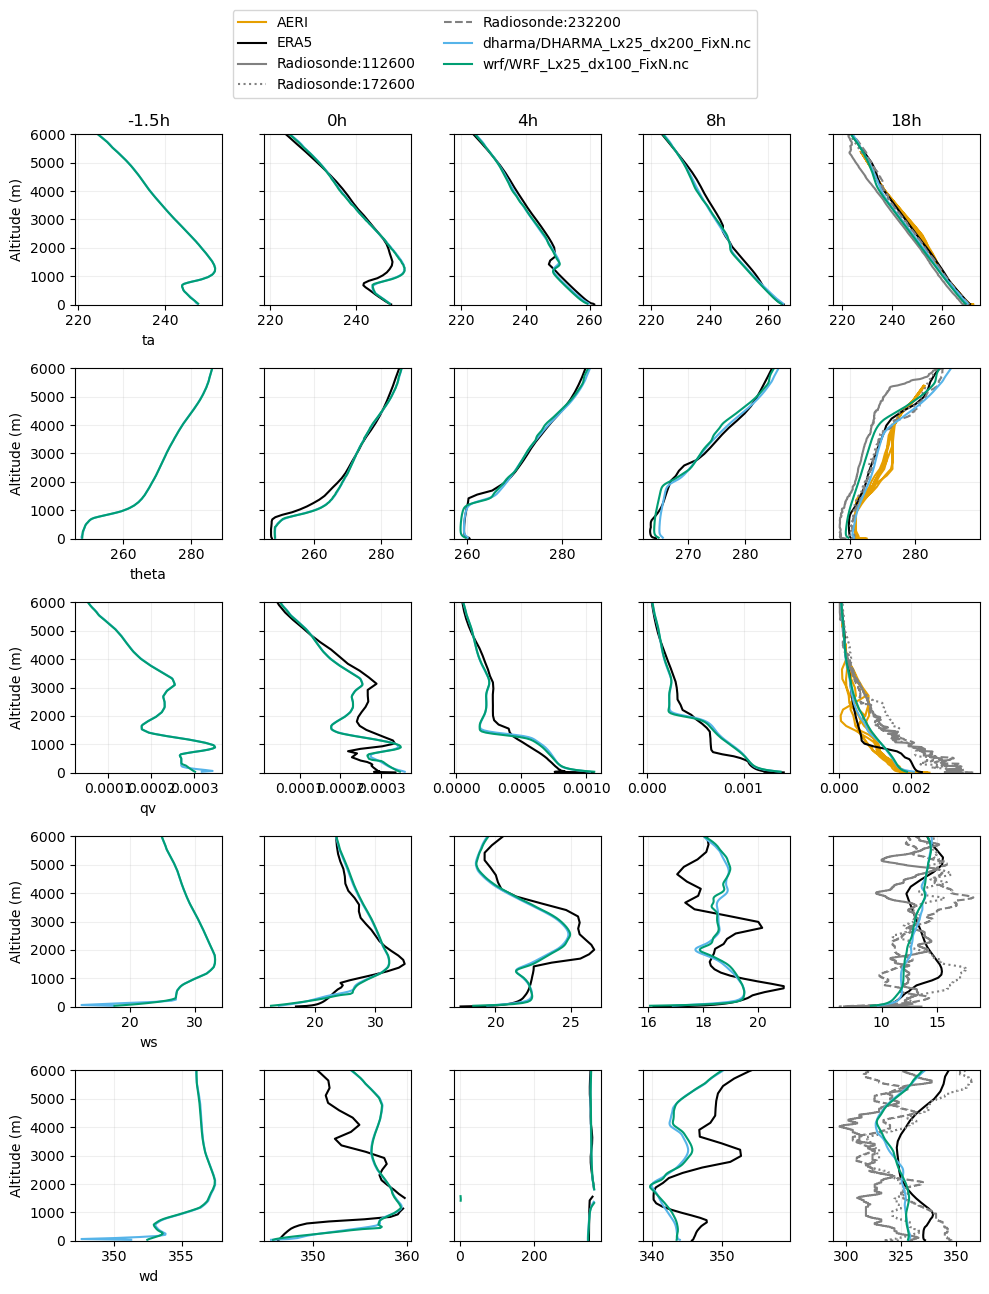

<Figure size 1000x600 with 0 Axes>

In [52]:
plot_2d(pd.concat([df_col_wrf_2d,df_col_dharma_2d,era5_2d,rs_dat,aeri_dat]),var_vec = ['ta','theta','qv','ws','wd'],times=[-1.5,0,4,8,18],z_max=6000)